Import libraries and useful functions.

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import torchvision
import torchvision.transforms as transforms
from torchvision.utils import make_grid
from sklearn import metrics
from itertools import product
import math
from scipy.optimize import minimize

sns.set_style("whitegrid")

def accuracy(target, pred):
    return metrics.accuracy_score(target.detach().cpu().numpy(), pred.detach().cpu().numpy())

def compute_confusion_matrix(target, pred, normalize=None, n_classes=10):
    return metrics.confusion_matrix(
        target.detach().cpu().numpy(),
        pred.detach().cpu().numpy(),
        labels=np.arange(n_classes),
        normalize=normalize
    )

def show_image(img):
    img = img.detach().cpu()
    img = img / 2 + 0.5   # unnormalize
    with sns.axes_style("white"):
        plt.figure(figsize=(8, 8))
        plt.imshow(img.permute((1, 2, 0)).numpy())
        plt.axis('off')
        plt.show()

Load the CIFAR-10 dataset and split it into train, validation, calibration and test sets.

In [2]:
# The output of torchvision datasets are PIL images in the range [0, 1]. 
# We transform them to PyTorch tensors and rescale them to be in the range [-1, 1].
transform = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ]
)

batch_size = 64

# Load full training dataset (50,000 samples)
full_train_set = torchvision.datasets.CIFAR10(
    root='./data', train=True, download=True, transform=transform
)

# Split into train (35k), validation (5k) and calibration (10k) sets
train_size = 35000 # 35,000
valid_size = 5000 # 5,000
calib_size = 10000 # 10,000

train_set, valid_set, calib_set = torch.utils.data.random_split(
    full_train_set, [train_size, valid_size, calib_size]
)

# Test set remains unchanged
test_set = torchvision.datasets.CIFAR10(
    root='./data', train=False, download=True, transform=transform
)

# DataLoaders
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=0)
valid_loader = DataLoader(valid_set, batch_size=batch_size, shuffle=True, num_workers=0)
calib_loader = DataLoader(calib_set, batch_size=batch_size, shuffle=False, num_workers=0)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False, num_workers=0)

# Map from class index to class name.
classes = {index: name for name, index in full_train_set.class_to_idx.items()}

# printing out each data category to make sure it has been set up correctly
print("Training data")
print("Number of points:", len(train_set))
x, y = next(iter(train_loader))
print("Batch dimension (B x C x H x W):", x.shape)
print(f"Number of distinct labels: {len(set(train_set.dataset.targets))} (unique labels: {set(train_set.dataset.targets)})")

print("\nValidation data")
print("Number of points:", len(valid_set))
x, y = next(iter(valid_loader))
print("Batch dimension (B x C x H x W):", x.shape)
print(f"Number of distinct labels: {len(set(valid_set.dataset.targets))} (unique labels: {set(valid_set.dataset.targets)})")

print("\nCalibration data")
print("Number of points:", len(calib_set))
x, y = next(iter(calib_loader))
print("Batch dimension (B x C x H x W):", x.shape)
print(f"Number of distinct labels: {len(set(calib_set.dataset.targets))} (unique labels: {set(calib_set.dataset.targets)})")

print("\nTest data")
print("Number of points:", len(test_set))
x, y = next(iter(test_loader))
print("Batch dimension (B x C x H x W):", x.shape)
print(f"Number of distinct labels: {len(set(test_set.targets))} (unique labels: {set(test_set.targets)})")

n_classes = len(set(test_set.targets))

Training data
Number of points: 35000
Batch dimension (B x C x H x W): torch.Size([64, 3, 32, 32])
Number of distinct labels: 10 (unique labels: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9})

Validation data
Number of points: 5000
Batch dimension (B x C x H x W): torch.Size([64, 3, 32, 32])
Number of distinct labels: 10 (unique labels: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9})

Calibration data
Number of points: 10000
Batch dimension (B x C x H x W): torch.Size([64, 3, 32, 32])
Number of distinct labels: 10 (unique labels: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9})

Test data
Number of points: 10000
Batch dimension (B x C x H x W): torch.Size([64, 3, 32, 32])
Number of distinct labels: 10 (unique labels: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9})


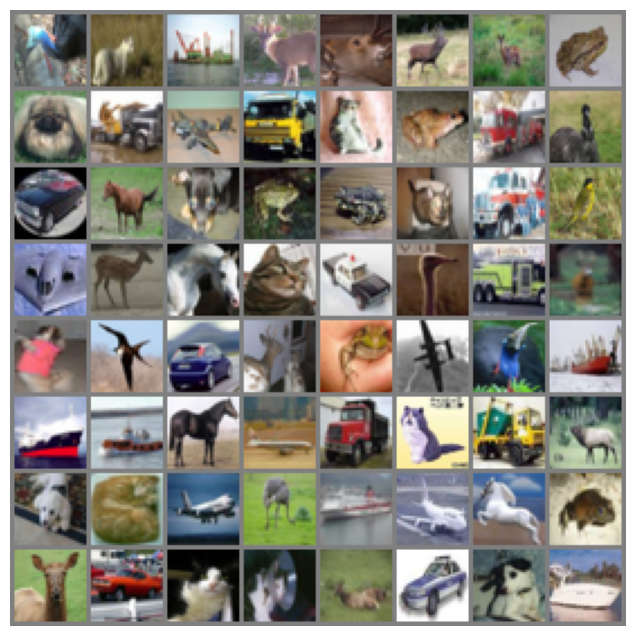

In [3]:
# Get random training images and show them.
images, labels = next(iter(train_loader))
show_image(torchvision.utils.make_grid(images))

Define model architecture and forward pass.

In [4]:
# Define a neural network model
class Model(nn.Module):
    def __init__(self, num_classes):
        super().__init__()

        # Store number of classes and activation function
        self.num_classes = num_classes
        self.activation_fn = nn.ReLU

        # Build the model architecture
        self.net = nn.Sequential(
            # Convolutional layers
            nn.Conv2d(3, 32, 5),          # First convolution
            self.activation_fn(),         # Activation
            nn.MaxPool2d(2),              # Pooling layer

            nn.Conv2d(32, 64, 3),         # Second convolution
            self.activation_fn(),         # Activation
            nn.MaxPool2d(2),              # Pooling layer
            #nn.Dropout(0.2),             # Optional dropout

            # Flatten for transition to fully connected layers
            nn.Flatten(),

            # Fully connected layers
            nn.LazyLinear(128),           # Lazy linear layer
            self.activation_fn(),         # Activation

            nn.Linear(128, 128),          # Hidden layer
            self.activation_fn(),         # Activation

            nn.Linear(128, 128),          # Hidden layer
            self.activation_fn(),         # Activation

            nn.Linear(128, num_classes)   # Output layer
        )

    # Forward pass
    def forward(self, x):
        return self.net(x)

Initialize grid for grid search and the loss function.

In [5]:
# Define grid
param_grid = {
    "optimizer": ["Adam", "SGD"],
    "lr": [1e-1, 1e-3, 1e-5]
    }

# Create iterable list of param combinations
keys = param_grid.keys()
values = param_grid.values()

combinations = list(product(*values))
print(combinations)

for combo in combinations:
    print(combo[0])

# Define loss function
loss_fn = nn.CrossEntropyLoss()  

[('Adam', 0.1), ('Adam', 0.001), ('Adam', 1e-05), ('SGD', 0.1), ('SGD', 0.001), ('SGD', 1e-05)]
Adam
Adam
Adam
SGD
SGD
SGD


Perform grid search cross-validation.

In [6]:
num_epochs = 8 # train model for longer
accuracy_every_steps = 500

best_accuracy = -np.inf
best_param = []

train_accuracies = []

# Loop over parameter combinations
for combo in combinations:
    model = Model(n_classes)
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    model.train()

    step = 0
    valid_accuracies = []

    # Retrieve learning rate
    lr = combo[1]
    
    # Retrive optimizer
    if combo[0] == "Adam":
        optimizer = optim.Adam(model.parameters(), lr=lr)
    else:
        optimizer = optim.SGD(model.parameters(), lr=lr) 
        
    # Train model
    for epoch in range(num_epochs):
        
        train_accuracies_batches = []
        
        for inputs, targets in train_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            
            # Forward pass, compute gradients, perform one training step.
            # Compute outputs
            output = model(inputs)

            # Compute loss
            loss = loss_fn(output, targets)

            # Zero gradients
            optimizer.zero_grad()

            # Backprop
            loss.backward()

            # One step of gradient descent
            optimizer.step()
            
            # Increment step counter
            step += 1
            
            # Compute accuracy.
            predictions = output.max(1)[1]
            train_accuracies_batches.append(accuracy(targets, predictions))
            
            # Compute trian accuracy every  steps.
            if step % accuracy_every_steps == 0:
                train_accuracies.append(np.mean(train_accuracies_batches))
                print(f"Step {step:<5}   training accuracy: {train_accuracies[-1]}")

    # Perfrom cross validation
    model.eval()
    with torch.no_grad():
        for inputs, targets in valid_loader:
            inputs, targets = inputs.to(device), targets.to(device)
                
            # Forward pass, compute gradients, perform one training step.
            # Compute outputs
            output = model(inputs)
                
            # Increment step counter
            step += 1
                
            # Compute accuracy.
            predictions = output.max(1)[1]
            valid_accuracies.append(accuracy(targets, predictions))

        mean_valid_accuracy = np.mean(valid_accuracies)
        print(f"Validation accuracy for combo {combo}: {mean_valid_accuracy}")

        if mean_valid_accuracy > best_accuracy:
            best_accuracy = mean_valid_accuracy
            best_param = combo


print("Finished training.")
print("Best params:", best_param)
print("Best accuract:", best_accuracy)

Step 500     training accuracy: 0.097375
Step 1000    training accuracy: 0.0997171633554084
Step 1500    training accuracy: 0.09836822660098522
Step 2000    training accuracy: 0.10093140668523677
Step 2500    training accuracy: 0.10166266025641026
Step 3000    training accuracy: 0.09811320754716982
Step 3500    training accuracy: 0.10070240825688073
Step 4000    training accuracy: 0.10307017543859649
Validation accuracy for combo ('Adam', 0.1): 0.09849683544303797
Step 500     training accuracy: 0.39396875
Step 1000    training accuracy: 0.5492894591611479
Step 1500    training accuracy: 0.6351985837438424
Step 2000    training accuracy: 0.6868036211699164
Step 2500    training accuracy: 0.7349258814102564
Step 3000    training accuracy: 0.7790683962264151
Step 3500    training accuracy: 0.8038990825688074
Step 4000    training accuracy: 0.8411915204678363
Validation accuracy for combo ('Adam', 0.001): 0.6880933544303798
Step 500     training accuracy: 0.158
Step 1000    training accur

Train the model using best parameters.

In [7]:
# Initialize the model with the given number of classes
model = Model(n_classes)

# Select device (GPU if available, otherwise CPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Move the model to the selected device
model.to(device)

# Set the model to training mode
model.train()

# Extract learning rate from best_param
lr = best_param[1]

# Choose optimizer based on best_param (Adam or SGD)
if best_param[0] == "Adam":
    optimizer = optim.Adam(model.parameters(), lr=lr)
else:
    optimizer = optim.SGD(model.parameters(), lr=lr)

# Define the loss function for classification
loss_fn = nn.CrossEntropyLoss()  


In [8]:
num_epochs = 8 # train model for longer
accuracy_every_steps = 500

step = 0

train_accuracies = []
valid_accuracies = []
        
for epoch in range(num_epochs):
    
    train_accuracies_batches = []
    
    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        
        # Forward pass, compute gradients, perform one training step.
        # Compute outputs
        output = model(inputs)

        # Compute loss
        loss = loss_fn(output, targets)

        # Zero gradients
        optimizer.zero_grad()

        # Backprop
        loss.backward()

        # One step of gradient descent
        optimizer.step()
        
        # Increment step counter
        step += 1
        
        # Compute accuracy.
        predictions = output.max(1)[1]
        train_accuracies_batches.append(accuracy(targets, predictions))
        
        # Validate every `validation_every_steps` steps.
        if step % accuracy_every_steps == 0:
            train_accuracies.append(np.mean(train_accuracies_batches))
            print(f"Step {step:<5}   training accuracy: {train_accuracies[-1]}")

print("Finished training.")

Step 500     training accuracy: 0.40325
Step 1000    training accuracy: 0.5670184878587197
Step 1500    training accuracy: 0.6383158866995073
Step 2000    training accuracy: 0.6910689415041783
Step 2500    training accuracy: 0.7331229967948718
Step 3000    training accuracy: 0.7744693396226415
Step 3500    training accuracy: 0.8113532110091743
Step 4000    training accuracy: 0.8270285087719298
Finished training.


Function to Extract Probabilities (It iterates through a data loader and collects the model's output for every image.)

In [9]:
def get_all_logits_and_labels(model, loader, device):
    """
    Runs the model on the entire dataset in the loader and returns:
    - softmax_scores: (N, num_classes) array of probabilities
    - true_labels: (N,) array of integer labels
    """
    model.eval() # Set model to evaluation mode
    all_probs = []
    all_labels = []
    all_logits = []
    
    with torch.no_grad(): # Disable gradient calculation for speed
        for images, labels in loader:
            images = images.to(device)
            labels = labels.to(device)
            
            # Forward pass
            logits = model(images)
            
            # Apply Softmax to get probabilities (sum to 1)
            probs = torch.nn.functional.softmax(logits, dim=1)
            
            # Move to CPU and convert to numpy for easy processing later
            all_probs.append(probs.cpu().numpy())
            all_labels.append(labels.cpu().numpy())
            all_logits.append(logits.cpu().numpy())
            
    # Concatenate all batches into single arrays
    probs_array = np.concatenate(all_probs)
    labels_array = np.concatenate(all_labels)
    logits_array = np.concatenate(all_logits)
    
    return logits_array, probs_array, labels_array

Generate data for conformal prediction

In [10]:
# GENERATE DATA FOR CONFORMAL PREDICTION

# 1. Determine device (use the same one you used for training)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device) # Ensure model is on the right device

# 2. Get probabilities and labels for the Calibration set
# REPLACE 'valid_loader' with whatever you named your calibration/validation data loader
print("Getting predictions for Calibration/Validation set...")
val_logits, val_sm, val_labels = get_all_logits_and_labels(model, calib_loader, device)

# 3. Get probabilities and labels for the Test set
# REPLACE 'test_loader' with whatever you named your test data loader
print("Getting predictions for Test set...")
test_logits, test_sm, test_labels = get_all_logits_and_labels(model, test_loader, device)

# Check shapes to ensure it worked
print(f"Calibration Data Shape: {val_logits.shape}") # Should be (N_calib, 10)
print(f"Test Data Shape: {test_logits.shape}")       # Should be (N_test, 10)

Getting predictions for Calibration/Validation set...
Getting predictions for Test set...
Calibration Data Shape: (10000, 10)
Test Data Shape: (10000, 10)


Temperature Scaling

In [11]:
# Implement Temperature Scaling on Calibration Set


def compute_loss(T, logits, labels):
    # Computes the Negative Log Likelihood (NLL) loss for a given temperature T
    T = T[0] # minimize expects a 1D array
    if T <= 0: return np.inf # Temperature must be positive
    
    # Scale logits and apply softmax
    scaled_logits = logits / T
    scaled_log_probs = F.log_softmax(torch.tensor(scaled_logits), dim=1)
    
    # Use NLL Loss (equivalent to Cross-Entropy)
    loss = F.nll_loss(scaled_log_probs, torch.tensor(labels, dtype=torch.long))
    return loss.item()

# Assuming raw model outputs are saved (logits) before softmax:
# re-run `get_all_preds_and_labels` function to save `all_logits`.
# If you don't have logits, re-run evaluation now saving logits:
# logits, true_labels = get_all_logits_and_labels(model, val_loader, device)

# Assuming `val_logits` (N_calib, 10) and `val_labels` (N_calib)
# Find the optimal temperature T that minimizes loss on the calibration set
initial_T = [1.0] # Start at T=1
result = minimize(
    compute_loss, 
    initial_T, 
    args=(val_logits, val_labels), 
    method='L-BFGS-B', 
    bounds=((0.01, None),)
)

optimal_T = result.x[0]
print(f"Optimal Temperature T: {optimal_T:.4f}")

# Now, re-generate your softmax scores using this temperature
# Note: Softmax scores scale up/down with T, but the *ranks* remain the same.
val_sm_calibrated = F.softmax(torch.tensor(val_logits / optimal_T), dim=1).numpy()
test_sm_calibrated = F.softmax(torch.tensor(test_logits / optimal_T), dim=1).numpy()

# RE-RUN RAPS (and APS) using `val_sm_calibrated` and `test_sm_calibrated`
# You should see a large improvement in set size.

Optimal Temperature T: 1.5195


APS function

In [12]:
# APS HELPER FUNCTIONS

# Compute APS conformity scores
def get_aps_scores(softmax_scores, true_labels):
    """
    Computes conformity scores for APS: The cumulative probability 
    of the true class after sorting probabilities in descending order.
    """
    n = len(true_labels)
    scores = np.zeros(n)
    
    # Sort probabilities in descending order
    sorted_indices = np.argsort(softmax_scores, axis=1)[:, ::-1]
    sorted_probs = np.take_along_axis(softmax_scores, sorted_indices, axis=1)
    
    # Compute cumulative sums of sorted probabilities
    cum_probs = np.cumsum(sorted_probs, axis=1)
    
    # Find the cumulative prob where the true label appears
    for i in range(n):
        rank_of_true = np.where(sorted_indices[i] == true_labels[i])[0][0]
        scores[i] = cum_probs[i, rank_of_true]
        
    return scores

# Generate APS prediction sets
def get_aps_sets(softmax_scores, q_hat):
    """
    Creates prediction sets for new data.
    Includes classes from top-down until cumulative prob > q_hat.
    """
    n = len(softmax_scores)
    prediction_sets = []
    
    # Sort class probabilities and compute cumulative sums
    sorted_indices = np.argsort(softmax_scores, axis=1)[:, ::-1]
    sorted_probs = np.take_along_axis(softmax_scores, sorted_indices, axis=1)
    cum_probs = np.cumsum(sorted_probs, axis=1)
    
    # Build prediction set for each sample
    for i in range(n):
        cut_idx = np.searchsorted(cum_probs[i], q_hat)
        pred_set = sorted_indices[i, :cut_idx+1].tolist()
        prediction_sets.append(pred_set)
        
    return prediction_sets


RAPS function

In [13]:
# RAPS (Regularized Adaptive Prediction Sets)
# Reference: Angelopoulos et al. (2021)

# Function: Compute RAPS scores for each sample
def get_raps_scores(softmax_scores, true_labels, k_reg=0, lambda_reg=0.01):
    """
    RAPS adds a penalty (lambda * rank) to the cumulative score.
    k_reg: Rank starting from which we penalize (usually 0 or 1)
    lambda_reg: The penalty weight
    """
    n = len(true_labels)
    scores = np.zeros(n)
    
    # Sort probabilities in descending order
    sorted_indices = np.argsort(softmax_scores, axis=1)[:, ::-1]
    sorted_probs = np.take_along_axis(softmax_scores, sorted_indices, axis=1)
    
    # Compute cumulative probabilities
    cum_probs = np.cumsum(sorted_probs, axis=1)
    
    # Loop over each sample and compute RAPS score
    for i in range(n):
        # Find rank of true label in sorted predictions
        rank = np.where(sorted_indices[i] == true_labels[i])[0][0]
        
        # Standard APS cumulative score
        score = cum_probs[i, rank]
        
        # Add regularization penalty if rank > k_reg
        reg_term = lambda_reg * max(0, rank - k_reg)
        
        scores[i] = score + reg_term
        
    return scores


# Function: Generate RAPS prediction sets
def get_raps_sets(softmax_scores, q_hat, k_reg=0, lambda_reg=0.01):
    n = len(softmax_scores)
    prediction_sets = []
    
    # Sort probabilities in descending order
    sorted_indices = np.argsort(softmax_scores, axis=1)[:, ::-1]
    sorted_probs = np.take_along_axis(softmax_scores, sorted_indices, axis=1)
    
    # Compute cumulative probabilities
    cum_probs = np.cumsum(sorted_probs, axis=1)
    
    # Build prediction set for each sample
    for i in range(n):
        # Iterate over ranks until cumulative score + penalty reaches threshold
        current_set = []
        for r in range(10):  # Max 10 classes
            score = cum_probs[i, r] + lambda_reg * max(0, r - k_reg)
            current_set.append(sorted_indices[i, r])
            if score >= q_hat:
                break
        prediction_sets.append(current_set)
        
    return prediction_sets


Calibration

In [14]:
# 1. CALIBRATION STEP
alpha = 0.1
n_calib = len(val_labels)

# Method A: Threshold (THR) - Simple
# Score = 1 - softmax of true class (lower probability = higher non-conformity)
# We take (1-alpha) quantile of these scores.
# Note: Your existing code might use alpha quantile of raw prob; this is mathematically equivalent.
thr_scores = 1 - val_sm[np.arange(n_calib), val_labels] # OLD
# thr_scores = 1 - val_sm_calibrated[np.arange(n_calib), val_labels] # NEW (with temperature scaling)
q_hat_thr = np.quantile(thr_scores, np.ceil((n_calib + 1) * (1 - alpha)) / n_calib)
final_thr = 1 - q_hat_thr  # Convert back to probability threshold

# Method B: Adaptive Prediction Sets (APS)
# Score = Cumulative probability up to true class
aps_scores = get_aps_scores(val_sm, val_labels) # OLD 
# aps_scores = get_aps_scores(val_sm_calibrated, val_labels) # NEW (with temperature scaling)
q_hat_aps = np.quantile(aps_scores, np.ceil((n_calib + 1) * (1 - alpha)) / n_calib)

# USE RAPS INSTEAD OF APS
# Try small regularization, e.g., lambda=0.01 or 0.1
raps_scores = get_raps_scores(val_sm, val_labels, lambda_reg=0.05) # OLD 
# raps_scores = get_raps_scores(val_sm_calibrated, val_labels, lambda_reg=0.05) # NEW (with temperature scaling)
q_hat_raps = np.quantile(raps_scores, np.ceil((n_calib + 1) * (1 - alpha)) / n_calib)


print(f"Calibration complete (Alpha={alpha})")
print(f"THR Threshold: {final_thr:.4f} (Keep classes with Prob > {final_thr:.4f})")
print(f"APS Threshold: {q_hat_aps:.4f} (Sum classes until Prob > {q_hat_aps:.4f})")
print(f"RAPS Threshold: {q_hat_raps:.4f} (Sum classes until Prob > {q_hat_raps:.4f})")

# 2. INFERENCE ON TEST SET
# THR Sets # OLD
test_sets_thr = []
for i in range(len(test_sm)):
    # Find classes > threshold
    # Fix: Ensure set is never empty by always taking top-1 if nothing crosses threshold
    idx = np.where(test_sm[i] >= final_thr)[0]
    if len(idx) == 0:
        idx = np.array([np.argmax(test_sm[i])])
    test_sets_thr.append(idx.tolist())

# THR Sets # NEW (with temperature scaling)
# test_sets_thr = []
# for i in range(len(test_sm_calibrated)):
#     # Find classes > threshold
#     # Fix: Ensure set is never empty by always taking top-1 if nothing crosses threshold
#     idx = np.where(test_sm_calibrated[i] >= final_thr)[0]
#     if len(idx) == 0:
#         idx = np.array([np.argmax(test_sm_calibrated[i])])
#     test_sets_thr.append(idx.tolist())

# APS Sets
test_sets_aps = get_aps_sets(test_sm, q_hat_aps) # OLD
# test_sets_aps = get_aps_sets(test_sm_calibrated, q_hat_aps) # NEW (with temperature scaling)

# RAPS Sets
test_sets_raps = get_raps_sets(test_sm, q_hat_raps, lambda_reg=0.05)  # OLD
# test_sets_raps = get_raps_sets(test_sm_calibrated, q_hat_raps, lambda_reg=0.05) # NEW (with temperature scaling)

# 3. EVALUATION METRICS
def evaluate_cp(pred_sets, targets):
    coverage = np.mean([y in s for y, s in zip(targets, pred_sets)])
    avg_size = np.mean([len(s) for s in pred_sets])
    return coverage, avg_size

cov_thr, size_thr = evaluate_cp(test_sets_thr, test_labels)
cov_aps, size_aps = evaluate_cp(test_sets_aps, test_labels)
cov_raps, size_raps = evaluate_cp(test_sets_raps, test_labels)

# 4. COMPARISON TABLE
results = {
    "Method": ["Threshold (THR)", "Adaptive (APS)", "RAPS"],
    "Marginal Coverage": [cov_thr, cov_aps, cov_raps],
    "Avg. Set Size": [size_thr, size_aps, size_raps],
    "Target Coverage": [1-alpha, 1-alpha, 1-alpha]
}
df_results = pd.DataFrame(results)
display(df_results)

Calibration complete (Alpha=0.1)
THR Threshold: 0.0469 (Keep classes with Prob > 0.0469)
APS Threshold: 0.9995 (Sum classes until Prob > 0.9995)
RAPS Threshold: 1.0754 (Sum classes until Prob > 1.0754)


,Method,Marginal Coverage,Avg. Set Size,Target Coverage
0,Threshold (THR),0.8973,2.1231,0.9
1,Adaptive (APS),0.9962,5.8255,0.9
2,RAPS,0.9492,3.4409,0.9


Evaluate model performance on test set.

In [15]:
# Evaluate test set
calibration_plot = []
confusion_matrix = np.zeros((n_classes, n_classes))

with torch.no_grad():
    model.eval()
    test_accuracies = []
    for inputs, targets in test_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        output = model(inputs)

        probs = torch.softmax(output, dim=1)

        # Prediction set per batch
        pred_set = []

        # Add classes to prediction set
        # Loop over batch len = 64
        for i in range(len(probs)):
            # Extract largest probability and predicted class
            predicted_class = probs[i].argmax().item()
            confidence = probs[i].max().item()

            # Add to list as tuple (confidence, correct_class?)
            if predicted_class == targets[i].item():
                calibration_plot.append((confidence, 1))
            else:
                calibration_plot.append((confidence, 0))

            # Loop over individual probabilities len = 10
            for j in range(len(probs[i])):
                # Compute prediction sets ----> maybe change structure of pred sets for clarity if we have the time
                if probs[i][j] >= final_thr:
                    pred_set.append(j)

            # Show prediction sets
            #print("possible classes", pred_set)
            #print("true class", targets[i].item())
            pred_set = []

        predictions = output.max(1)[1]

        # Multiply by len(inputs) because the final batch of DataLoader may be smaller (drop_last=True).
        test_accuracies.append(accuracy(targets, predictions) * len(inputs))
        
        confusion_matrix += compute_confusion_matrix(targets, predictions)

    test_accuracy = np.sum(test_accuracies) / len(test_set)
    
    model.train()

print(f"Test accuracy: {test_accuracy:.3f}")

Test accuracy: 0.688


Prepare calibration plot bins.

In [16]:
# Create matrix with confidence bins
n_rows = 11
calibration_matrix = [[] for _ in range(n_rows)]

# Create bins
num_bins = 10
bins = np.linspace(0, 1, num_bins + 1)

# Split confidence and hit? into the respective bins
for i in range(len(calibration_plot)):
    confidence = calibration_plot[i][0]
    hit = calibration_plot[i][1]

    # Get index of respective bin
    bin_index = np.digitize(confidence, bins) - 1

    # Add tuple to list
    calibration_matrix[bin_index].append((confidence, hit))

print(calibration_matrix)


[[], [(0.17932814359664917, 0), (0.16906210780143738, 0)], [(0.25116410851478577, 1), (0.26571181416511536, 1), (0.27479034662246704, 0), (0.2743943929672241, 0), (0.25715571641921997, 1), (0.24408011138439178, 0), (0.24324893951416016, 1), (0.2942122220993042, 0), (0.23277826607227325, 0), (0.23761269450187683, 0), (0.2790524363517761, 0), (0.2833556532859802, 0), (0.24388323724269867, 0), (0.28694647550582886, 0), (0.2917564809322357, 0), (0.26868537068367004, 0), (0.2873932719230652, 0), (0.27756351232528687, 0), (0.23287653923034668, 1), (0.24131973087787628, 0), (0.2844994068145752, 0), (0.2733875513076782, 1), (0.2975882887840271, 1), (0.29434335231781006, 1), (0.271498441696167, 0), (0.2328263372182846, 0), (0.22015295922756195, 1), (0.27696773409843445, 0), (0.2936946153640747, 0), (0.2965922951698303, 0), (0.2442811280488968, 0), (0.2156108170747757, 0), (0.24579791724681854, 0), (0.2673781216144562, 0), (0.2632681131362915, 0), (0.2433728128671646, 0), (0.23910759389400482, 0

Prepare data for calibration curve.

In [17]:
x, y = [], []
sum, count = 0, 0

# Loop through bins
for row in calibration_matrix:
    # Check if bin non-empty
    if len(row) != 0:
        # Iterate through bin and compute average confidence and accuracy
        for item in row:
            sum += item[0]
            count += item[1]
        
        # Add to x and y lists
        x.append(sum / len(row))
        y.append(count / len(row))

        sum, count = 0, 0

#print(x)
#print(y)

Plot the calibration curve.

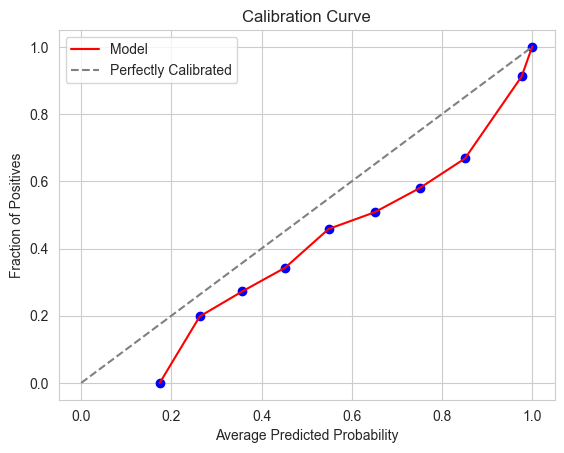

In [18]:
import matplotlib.pyplot as plt
# Perfectly calibrated line
x_perf = np.linspace(0, 1, 11)
y_perf = x_perf

# Plot calibration curve
plt.plot(x, y, label="Model", color='red')
plt.scatter(x, y, color='blue')
plt.plot(x_perf, y_perf, label="Perfectly Calibrated", linestyle='--', color='gray')
plt.title("Calibration Curve")
plt.xlabel("Average Predicted Probability")
plt.ylabel("Fraction of Positives")
plt.legend(loc="upper left")
plt.show()

UPDATE PLOTS TO INCLUDE CONFORMAL PREDICTION

Plot confusion matrix for test set.

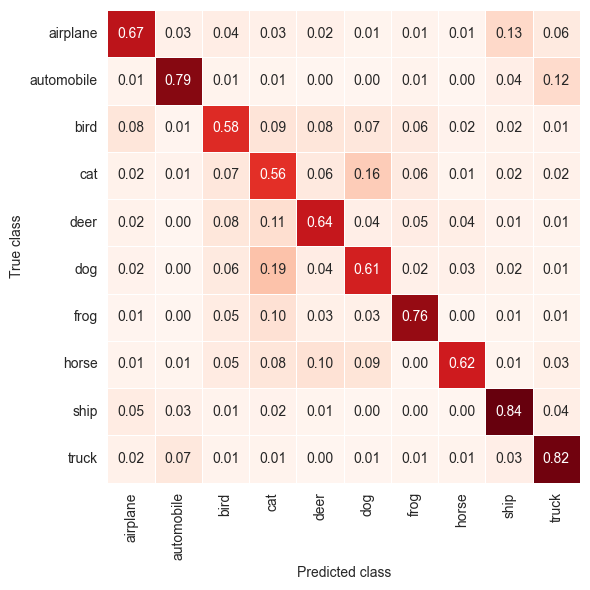

In [19]:
# Function to normalize the confusion matrix along a given axis
def normalize(matrix, axis):
    axis = {'true': 1, 'pred': 0}[axis]
    return matrix / matrix.sum(axis=axis, keepdims=True)

# Prepare x-axis labels based on class names
x_labels = [classes[i] for i in classes]

# Use same labels for y-axis
y_labels = x_labels

# Create a square figure for the heatmap
plt.figure(figsize=(6, 6))

# Plot the normalized confusion matrix heatmap
sns.heatmap(
    ax=plt.gca(),
    data=normalize(confusion_matrix, 'true'),
    annot=True,
    linewidths=0.5,
    cmap="Reds",
    cbar=False,
    fmt=".2f",
    xticklabels=x_labels,
    yticklabels=y_labels,
)

# Rotate x-axis labels for readability
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.ylabel("True class")
plt.xlabel("Predicted class")
plt.tight_layout()
plt.show()


Plot per class accuracy of predictions.

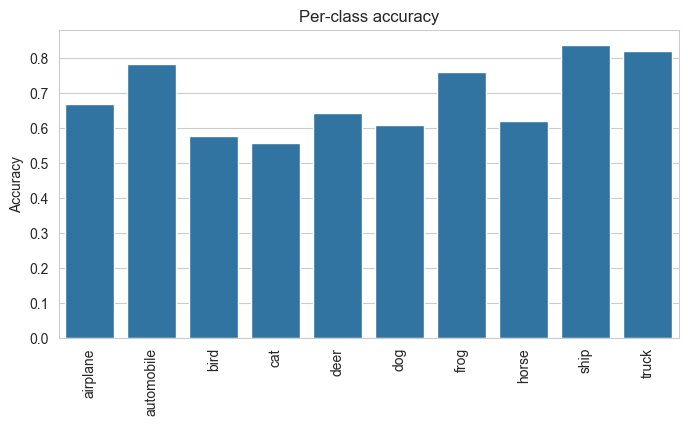

In [20]:
with sns.axes_style('whitegrid'):
    plt.figure(figsize=(8, 4))
    sns.barplot(x=x_labels, y=np.diag(normalize(confusion_matrix, 'true')))
    plt.xticks(rotation=90)
    plt.title("Per-class accuracy")
    plt.ylabel("Accuracy")
    plt.show()

Baseline + APS + RAPS

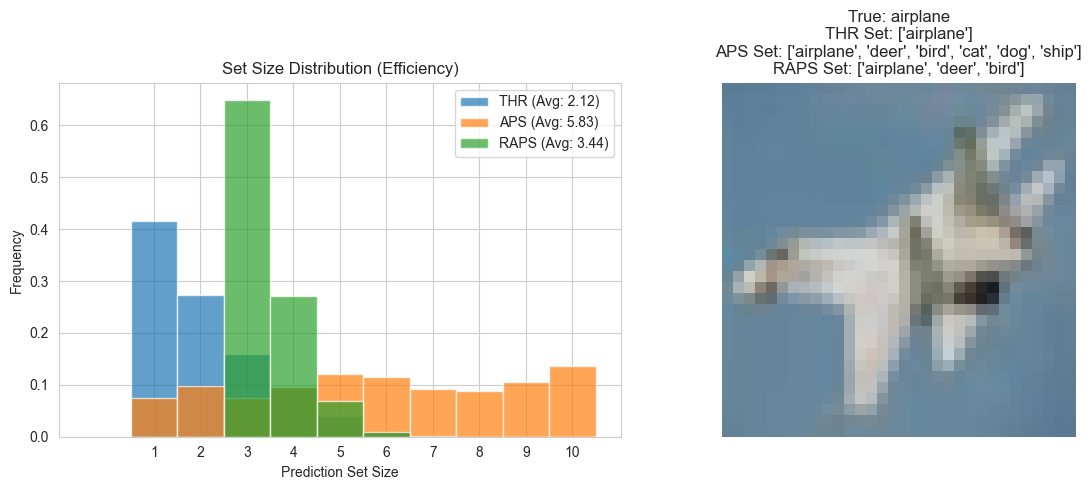

In [21]:
# VISUALIZATION
plt.figure(figsize=(12, 5))

# Plot 1: Set Size Distribution
plt.subplot(1, 2, 1)
plt.hist([len(s) for s in test_sets_thr], alpha=0.7, label=f'THR (Avg: {size_thr:.2f})', bins=np.arange(12)-0.5, density=True)
plt.hist([len(s) for s in test_sets_aps], alpha=0.7, label=f'APS (Avg: {size_aps:.2f})', bins=np.arange(12)-0.5, density=True)
plt.hist([len(s) for s in test_sets_raps], alpha=0.7, label=f'RAPS (Avg: {size_raps:.2f})', bins=np.arange(12)-0.5, density=True)
plt.xlabel('Prediction Set Size')
plt.ylabel('Frequency')
plt.title('Set Size Distribution (Efficiency)')
plt.xticks(range(1, 11))
plt.legend()

# Plot 2: Example of a "Hard" Image
# Find an image where APS produces a smaller or more logical set
plt.subplot(1, 2, 2)
hard_idx = 10  # Change this index to explore different examples
img_tensor = test_set[hard_idx][0]
# Undo normalization for display
img_display = img_tensor / 2 + 0.5 
plt.imshow(np.transpose(img_display.numpy(), (1, 2, 0)))
plt.axis('off')
plt.title(f"True: {classes[test_labels[hard_idx]]}\n"
          f"THR Set: {[classes[i] for i in test_sets_thr[hard_idx]]}\n"
          f"APS Set: {[classes[i] for i in test_sets_aps[hard_idx]]}\n"
          f"RAPS Set: {[classes[i] for i in test_sets_raps[hard_idx]]}")

plt.tight_layout()
plt.show()

Fairness & Difficulty

['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


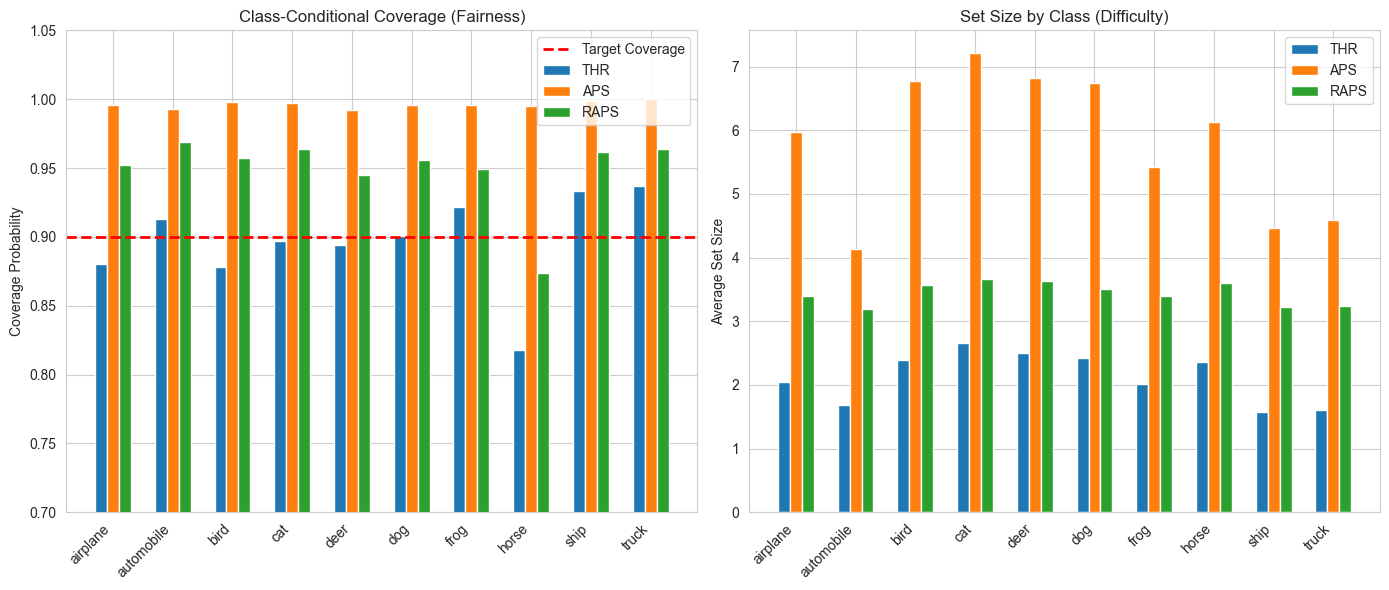

In [22]:
"""
    Calculates coverage and average set size for each class subgroup.
"""

def calculate_per_class_metrics(prediction_sets, true_labels, n_classes):
    # Initialize containers for raw counts/sizes
    class_coverages = np.zeros(n_classes)
    class_set_sizes = [[] for _ in range(n_classes)]
    class_counts = np.zeros(n_classes)

    # 1. Iterate through every sample in the test set
    for y_true, pred_set in zip(true_labels, prediction_sets):
        class_index = y_true # Assuming y_true is the 0-indexed integer label
        
        # Update count for this class
        class_counts[class_index] += 1
        
        # Check for coverage (Did the set contain the true label?)
        if y_true in pred_set:
            class_coverages[class_index] += 1
            
        # Store the set size for later averaging
        class_set_sizes[class_index].append(len(pred_set))

    # 2. Final calculation: divide counts by totals
    per_class_coverage = class_coverages / class_counts
    
    # Handle classes that might not appear in the test set (if data split is small)
    per_class_size = np.array([np.mean(sizes) if sizes else 0 for sizes in class_set_sizes])
    
    return per_class_coverage, per_class_size

# Example Usage
# Assuming you have test_sets_thr, test_sets_aps, test_sets_raps, test_labels, and n_classes=10
n_classes = 10 
# You will need to define your `class_names` list for the plot labels

cov_thr_individual, size_thr_individual = calculate_per_class_metrics(test_sets_thr, test_labels, n_classes)
cov_aps_individual, size_aps_individual = calculate_per_class_metrics(test_sets_aps, test_labels, n_classes)
cov_raps_individual, size_raps_individual = calculate_per_class_metrics(test_sets_raps, test_labels, n_classes)

# Now, use cov_thr, cov_aps, cov_raps, etc., in the plotting function I provided earlier.

def plot_class_conditional_metrics(methods_data, class_names, alpha):
    n_classes = len(class_names)
    target_coverage = 1.0 - alpha
    
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))

    # PLOT 1: COVERAGE
    for name, cov_data, size_data in methods_data:
        axes[0].bar(np.arange(n_classes) + 0.2 * methods_data.index( (name, cov_data, size_data) ) , 
                    cov_data, 
                    width=0.2, 
                    label=name)
        
    axes[0].axhline(target_coverage, color='red', linestyle='--', linewidth=2, label="Target Coverage")
    axes[0].set_xticks(np.arange(n_classes) + 0.2)
    axes[0].set_xticklabels(class_names, rotation=45, ha='right')
    axes[0].set_ylim(0.7, 1.05)
    axes[0].set_ylabel("Coverage Probability")
    axes[0].set_title("Class-Conditional Coverage (Fairness)")
    axes[0].legend()

    # PLOT 2: AVERAGE SET SIZE
    for name, cov_data, size_data in methods_data:
        axes[1].bar(np.arange(n_classes) + 0.2 * methods_data.index( (name, cov_data, size_data) ), 
                    size_data, 
                    width=0.2, 
                    label=name)
        
    axes[1].set_xticks(np.arange(n_classes) + 0.2)
    axes[1].set_xticklabels(class_names, rotation=45, ha='right')
    axes[1].set_ylabel("Average Set Size")
    axes[1].set_title("Set Size by Class (Difficulty)")
    axes[1].legend()
    
    plt.tight_layout()
    plt.show()

class_names = [classes[i] for i in range(n_classes)]
print(class_names)

# Example Call:
methods_data = [
    ("THR", cov_thr_individual, size_thr_individual),
    ("APS", cov_aps_individual, size_aps_individual),
    ("RAPS", cov_raps_individual, size_raps_individual)
]
plot_class_conditional_metrics(methods_data, class_names, alpha)

OVERLAP MATRIX 

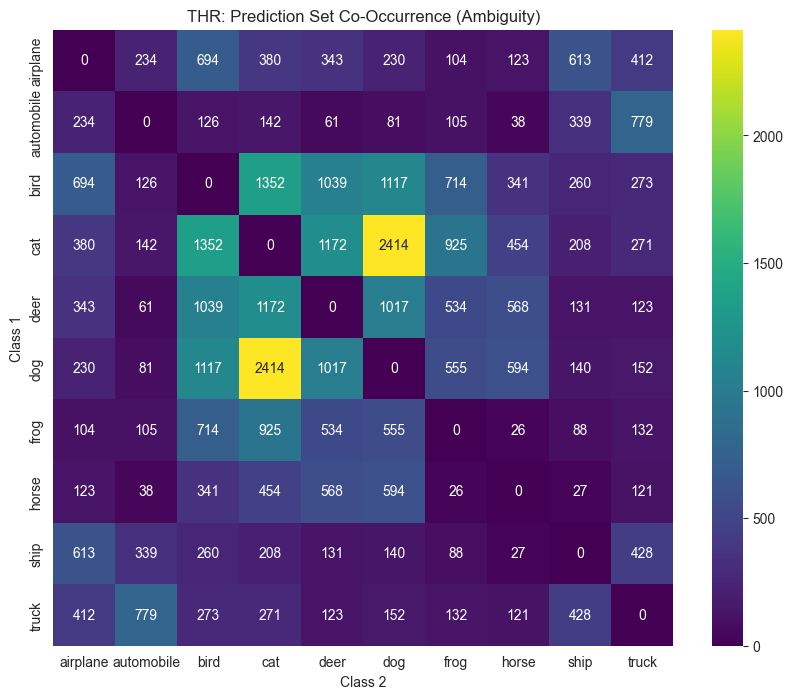

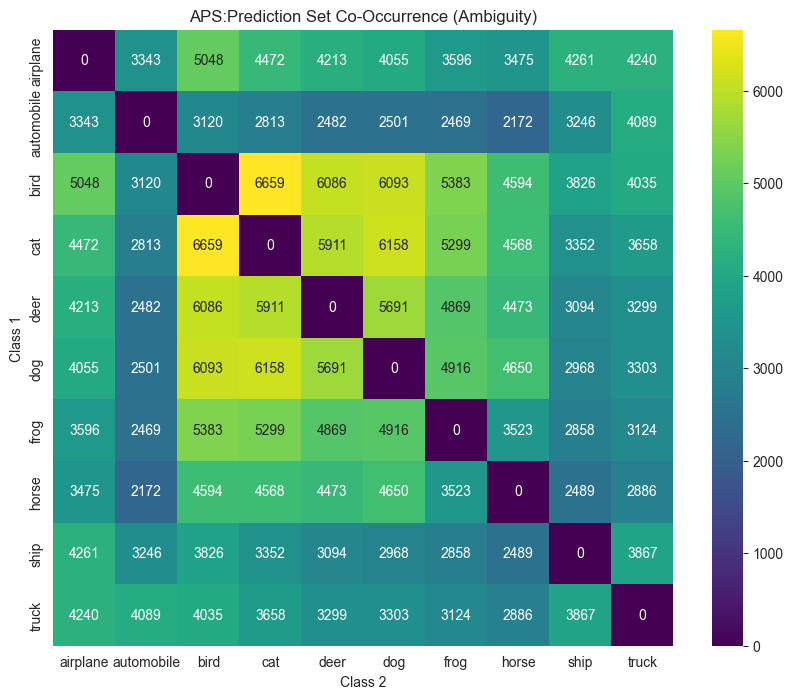

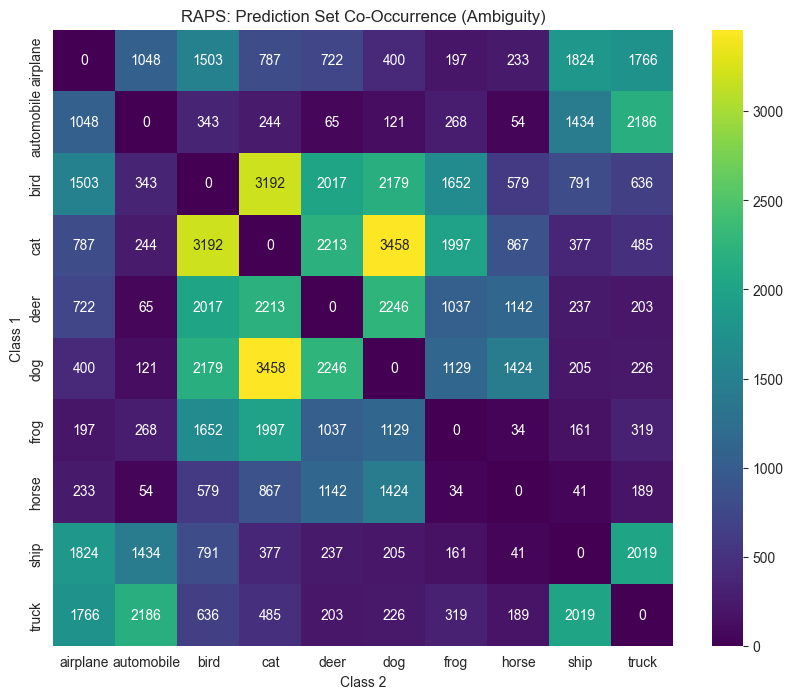

In [23]:

# Requires test_sets (e.g., test_sets_raps) and n_classes (10)

def build_co_occurrence_matrix(prediction_sets, n_classes):
    matrix = np.zeros((n_classes, n_classes))
    for s in prediction_sets:
        # Iterate over all unique pairs of classes in the set
        for i in range(len(s)):
            for j in range(len(s)):
                if i != j:
                    matrix[s[i], s[j]] += 1
    
    # Normalize by the number of times the first class appeared
    # (Optional: can just use raw counts)
    return matrix

co_matrix = build_co_occurrence_matrix(test_sets_thr, n_classes)

plt.figure(figsize=(10, 8))
sns.heatmap(co_matrix, 
            annot=True, 
            fmt=".0f", 
            cmap="viridis", 
            xticklabels=class_names, 
            yticklabels=class_names)

plt.title("THR: Prediction Set Co-Occurrence (Ambiguity)")
plt.xlabel("Class 2")
plt.ylabel("Class 1")

co_matrix = build_co_occurrence_matrix(test_sets_aps, n_classes)

plt.figure(figsize=(10, 8))
sns.heatmap(co_matrix, 
            annot=True, 
            fmt=".0f", 
            cmap="viridis", 
            xticklabels=class_names, 
            yticklabels=class_names)

plt.title("APS:Prediction Set Co-Occurrence (Ambiguity)")
plt.xlabel("Class 2")
plt.ylabel("Class 1")

co_matrix = build_co_occurrence_matrix(test_sets_raps, n_classes)

plt.figure(figsize=(10, 8))
sns.heatmap(co_matrix, 
            annot=True, 
            fmt=".0f", 
            cmap="viridis", 
            xticklabels=class_names, 
            yticklabels=class_names)

plt.title("RAPS: Prediction Set Co-Occurrence (Ambiguity)")
plt.xlabel("Class 2")
plt.ylabel("Class 1")
plt.show()